In [1]:
# !pip3 install sentence_transformers
# !pip3 install torchview
# !pip install torchsummary
# !brew install graphviz
# !pip install torchviz
%load_ext autotime

import torch
import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sentence_transformers import SentenceTransformer, losses
import pandas as pd
import numpy as np
import torch.nn.functional as F
from tqdm.notebook import tqdm
tqdm.pandas()
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
# from torchview import draw_graph
# from torchsummary import summary
pd.set_option("max_colwidth", None)

from peft import LoraConfig, get_peft_model, prepare_model_for_int8_training, TaskType, PeftModel # peft-0.7.1
from transformers import (
    AutoModel,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    AutoTokenizer,
    TrainingArguments,
    AutoConfig,
)

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import entropy


time: 7.49 s (started: 2024-08-20 13:22:28 +00:00)


In [2]:
import torch
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel
# !huggingface-cli login
my_token = "YOUR_HF_TOKEN"
model_path = 'nvidia/NV-Embed-v1'

# load model with tokenizer
text_config = {"_name_or_path": "mistralai/Mistral-7B-v0.1"}
model = AutoModel.from_pretrained(
            "nvidia/NV-Embed-v1",
            trust_remote_code=True,
            text_config=text_config,
        )
tokenizer = AutoTokenizer.from_pretrained(model_path, token=my_token)


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): Traceback (most recent call last):
  File "/home/vahid_ghafouri/.local/b

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

/home/vahid_ghafouri/.cache/huggingface/modules/transformers_modules/modeling_nvembed.py:348: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),


[[75.47944641113281, 0.4871984124183655], [4.265612602233887, 77.76407623291016]]
time: 1min 16s (started: 2024-08-20 13:23:03 +00:00)


In [3]:
def batch_and_encode_others(df_sentences_col,finetuned_model_x,is_lora, model=model):
    
    torch.cuda.empty_cache()

    # Move the model to the appropriate device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    # Assuming you have a DataFrame named df with columns "sentence_i" and "sentence_j"
    dataset_i = CustomDataset(df_sentences_col.tolist())

    # Use DataLoader for batch processing
    batch_size = 10
    dataloader_i = DataLoader(dataset_i, batch_size=batch_size, shuffle=False)

    # Lists to store the embeddings for "sentence_i" and "sentence_j"
    embeddings_i_list = []


    # Encode sentences in batches
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        for sentences_i_batch in tqdm(dataloader_i):
            
            embeddings_i = model.encode(sentences_i_batch, max_length=max_length).tolist()
            embeddings_i = [[round(value, 4) for value in row] for row in embeddings_i]
            embeddings_i_list.extend(embeddings_i)
    return embeddings_i_list

time: 10.2 ms (started: 2024-08-20 13:24:56 +00:00)


In [7]:
meta_data=pd.read_excel('/StanceAwareSBERT/Datasets/Kialo_MetaData_all.xlsx')
sentence_pairs_df = pd.concat([pd.read_csv('Datasets/argument_pairs_branchleaf.csv'),pd.read_csv('Datasets/argument_pairs_leafleaf.csv')],ignore_index=True)
sentence_pairs_df['url'] = sentence_pairs_df['post_id'].map(dict(zip(meta_data['post_id'],meta_data['url'])))
sentence_pairs_df = sentence_pairs_df[(sentence_pairs_df['stance']=='Pro') | (sentence_pairs_df['stance']=='Con')]
sentence_pairs_df['stance_numeric'] = sentence_pairs_df['stance'].map({'Pro':1,'Con':0})
print(f"original length: {len(sentence_pairs_df)}")
sentence_pairs_df = sentence_pairs_df.dropna()
print(f"length after droping nulls: {len(sentence_pairs_df)}")
sentence_pairs_df = sentence_pairs_df[sentence_pairs_df['sentence_i'] != sentence_pairs_df['sentence_j']]
sentence_pairs_df['sorted_sentences'] = sentence_pairs_df.progress_apply(lambda row: tuple(sorted([row['sentence_i'], row['sentence_j']])), axis=1)
sentence_pairs_df.drop_duplicates(subset='sorted_sentences',inplace=True)
sentence_pairs_df.drop(columns=['sorted_sentences'],inplace=True)
print(f"length after dropping duplicates: {len(sentence_pairs_df)}")
sentence_pairs_df = sentence_pairs_df[(sentence_pairs_df['sentence_i'].progress_apply(lambda x: len(x.split(' ')))>3) & (sentence_pairs_df['sentence_j'].progress_apply(lambda x: len(x.split(' ')))>3)]
print(f"length after removing short sentences: {len(sentence_pairs_df)}")
# Splitting into train and test sets
# sentence_pairs_df, sentence_pairs_test_df = train_test_split(sentence_pairs_df, test_size=0.1, random_state=1)
# Group the DataFrame by "post_id"
meta_data = meta_data[meta_data['language']=='en']
post_id_set = list(set(list(meta_data["post_id"])))

# Initialize empty lists for train and test indices
train_indices = []
test_indices = []


train_indices, test_indices = train_test_split(post_id_set, test_size=0.1, random_state=1)  # Adjust the test_size as needed

# Split the original DataFrame using the train and test indices
sentence_pairs_train_df = sentence_pairs_df[sentence_pairs_df["post_id"].isin(train_indices)]
sentence_pairs_test_df = sentence_pairs_df[sentence_pairs_df["post_id"].isin(test_indices)]
print(f"length of train-set: {len(sentence_pairs_train_df)}")
print(f"length of test-set: {len(sentence_pairs_test_df)}")

sentence_pairs_test_df.reset_index(drop=True,inplace=True)

original length: 1134249
length after droping nulls: 1134249


  0%|          | 0/1133848 [00:00<?, ?it/s]

length after dropping duplicates: 1108680


  0%|          | 0/1108680 [00:00<?, ?it/s]

  0%|          | 0/1108680 [00:00<?, ?it/s]

length after removing short sentences: 1085119
length of train-set: 972395
length of test-set: 112724
time: 48.3 s (started: 2024-08-20 13:28:26 +00:00)


  0%|          | 0/11273 [00:00<?, ?it/s]

/home/vahid_ghafouri/.cache/huggingface/modules/transformers_modules/modeling_nvembed.py:348: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
/tmp/ipykernel_1408580/1809966408.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentence_pairs_test_df[f'embeddings_i_{finetuned_model_i}'] = batch_and_encode_others(df_sentences_col=sentence_pairs_test_df['sentence_i'],finetuned_model_x = finetuned_model_i,is_lora=False)


  0%|          | 0/11273 [00:00<?, ?it/s]

/home/vahid_ghafouri/.cache/huggingface/modules/transformers_modules/modeling_nvembed.py:348: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(batch_dict.get('input_ids').to(batch_dict.get('input_ids')).long()),
/tmp/ipykernel_1408580/1809966408.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentence_pairs_test_df[f'embeddings_j_{finetuned_model_i}'] = batch_and_encode_others(df_sentences_col=sentence_pairs_test_df['sentence_j'],finetuned_model_x = finetuned_model_i,is_lora=False)


  0%|          | 0/112724 [00:00<?, ?it/s]

/tmp/ipykernel_1408580/1809966408.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentence_pairs_test_df['cosine_similarity'] = sentence_pairs_test_df.progress_apply(lambda row: 1 - cosine(row[f'embeddings_i_{finetuned_model_i}'], row[f'embeddings_j_{finetuned_model_i}']), axis=1)


0.001108094064088478


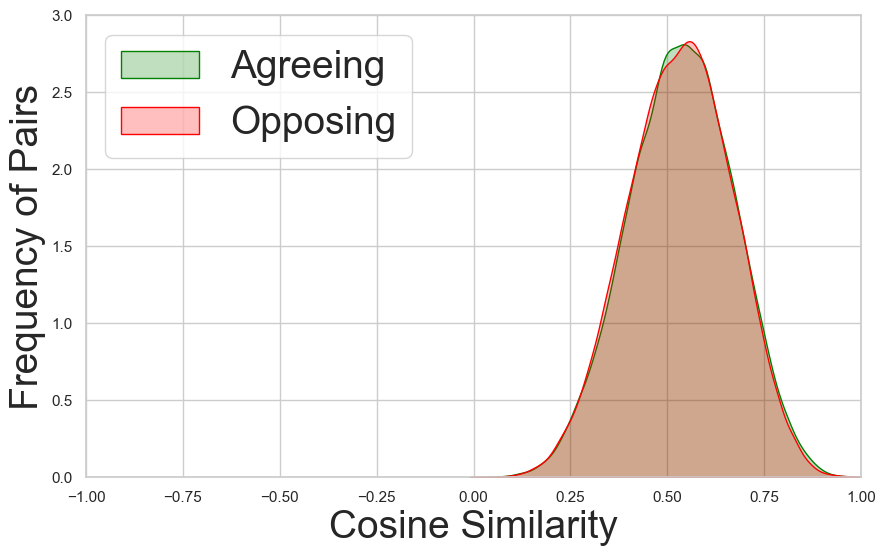

time: 1h 5min 27s (started: 2024-08-20 13:32:24 +00:00)


In [10]:
from scipy.stats import entropy

finetuned_model_i = 'original'

sentence_pairs_test_df[f'embeddings_i_{finetuned_model_i}'] = batch_and_encode_others(df_sentences_col=sentence_pairs_test_df['sentence_i'],finetuned_model_x = finetuned_model_i,is_lora=False)
sentence_pairs_test_df[f'embeddings_j_{finetuned_model_i}'] = batch_and_encode_others(df_sentences_col=sentence_pairs_test_df['sentence_j'],finetuned_model_x = finetuned_model_i,is_lora=False)
sentence_pairs_test_df['cosine_similarity'] = sentence_pairs_test_df.progress_apply(lambda row: 1 - cosine(row[f'embeddings_i_{finetuned_model_i}'], row[f'embeddings_j_{finetuned_model_i}']), axis=1)
# sentence_pairs_test_df = sentence_pairs_test_df[sentence_pairs_test_df['relationship']=="branch-leaf"]
# Set up Seaborn settings
sns.set(style="whitegrid")

# Extract cosine similarities for "Pro" and "Con" stances
cosine_similarity_pro = sentence_pairs_test_df[sentence_pairs_test_df['stance'] == 'Pro']#['cosine_similarity_new']
cosine_similarity_con = sentence_pairs_test_df[sentence_pairs_test_df['stance'] == 'Con']#['cosine_similarity_new']

# Calculate the histograms of cosine similarities
hist_pro, bin_edges_pro = np.histogram(cosine_similarity_pro['cosine_similarity'], bins=50, density=True)
hist_con, bin_edges_con = np.histogram(cosine_similarity_con['cosine_similarity'], bins=50, density=True)

# Calculate the probability distributions
pdf_pro = hist_pro / np.sum(hist_pro)
pdf_con = hist_con / np.sum(hist_con)

# Calculate KL Divergence
kl_divergence = entropy(pdf_pro, pdf_con)
print(kl_divergence)

# Create density plots for each stance
plt.figure(figsize=(10, 6))
sns.kdeplot(data=cosine_similarity_pro, x='cosine_similarity', label='Agreeing', fill=True,color='green')
sns.kdeplot(data=cosine_similarity_con, x='cosine_similarity', label='Opposing', fill=True,color='red')

# Add labels and title
plt.xlabel('Cosine Similarity', fontsize=28)
plt.ylabel('Frequency of Pairs', fontsize=28)
# plt.title(f'Cosine Similarities PDF - Test Set - Model: {finetuned_model_i}')
plt.xlim([-1,1])
plt.ylim([0,3])
# Show legend
plt.legend(loc='upper left',fontsize=28)

plt.savefig(f'Plots/testset_NV-Embed-v1_new.png', dpi=300, bbox_inches='tight')